In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy
import os
import json
from tqdm.auto import tqdm
import copy
from scipy.interpolate import splrep, BSpline
from matplotlib.patches import Rectangle
from global_functions import adjustmaps, plot_phase
import pickle as pickle
import itertools
from model import Model
import time
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.animation as animation

project = sg.get_project()
# schema = project.detect_schema(); schema

## Phase with fri uncertainty

In [3]:
metric = "lambda_s"
Aeff = 7.29
t_final = 600
A_cell = 270**2 / 1e6 #km^2
ncell_tot = 84_669 #should read this in
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/"
delta_tau_vec = np.load(fn_prefix + "delta_tau_vec.npy")
C_vec = np.load(fn_prefix + "C_vec.npy")
tauc_range_avg = C_vec / ncell_tot
ncell_vec = np.load(fn_prefix + "ncell_vec.npy")
alteration_areas = ncell_vec * A_cell
slice_left_all = np.load(fn_prefix + "slice_left_all.npy")
tauc_methods = ["flat", "initlinear", "initinverse"]
# print(full_phase.shape)
# print("delta_tau, C, ncell, tau_i")

ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
total_cells = np.count_nonzero(((sdm > 0) & (fdm > 0)).flatten())

In [4]:
delta_zero_i = np.nonzero(delta_tau_vec == 0)[0][0]
delta_tau_step = np.unique(np.diff(delta_tau_vec))[0]
'''Could set these limits based on metric bounds at delta_tau=0'''
dmin, dmax = (0.76, 0.96)
# dmin, dmax = (min(full_phase.flatten()), max(full_phase.flatten()))
thresh_vec_rob = np.linspace(dmin, dmax, 100)
# Initialize data for the max robustness per (C, ncell, threshold, fric_method) combination
robustness_all = np.ones((len(tauc_methods), len(thresh_vec_rob), len(ncell_vec), len(C_vec))) * np.nan
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    full_phase = np.load(fn_prefix + f"/metric_{metric}/phase_{tauc_method}.npy")
    for thresh_i, thresh in enumerate(thresh_vec_rob):
        robustness = np.ones((len(ncell_vec), len(C_vec))) * np.nan
        for i, j in itertools.product(range(robustness.shape[0]), range(robustness.shape[1])):
            # Take slice of full_phase at (C, ncell) with axes (delta_tau, tau_i)
            phase_slice = full_phase[:, j, i, :]

            '''Should set a tolerance for how much lower than threshold, rather than hard limit'''
            gt_thresh_counts = np.ones_like(slice_left_all)*np.nan
            for sl_i, slice_left in enumerate(slice_left_all):
                # First check that threshold is met with delta_tau=0
                # If threshold not met at zero uncertainty, this outcome is infeasible
                # Keep robustness of such outcomes as nan
                delta_zero_check1 = np.isnan(phase_slice[delta_zero_i, sl_i])
                delta_zero_check2 = (phase_slice[delta_zero_i, sl_i] < thresh)
                if delta_zero_check1 or delta_zero_check2: continue
                # Check delta_tau < 0
                lt_check = phase_slice[:delta_zero_i, sl_i] < thresh
                lt_check = np.flip(lt_check)
                count_left = np.nonzero(lt_check)[0][0] if np.any(lt_check) else len(lt_check)
                # Then check delta_tau > 0
                lt_check = phase_slice[delta_zero_i+1:, sl_i] < thresh
                count_right = np.nonzero(lt_check)[0][0] if np.any(lt_check) else len(lt_check)
                # Use the minimum to calculate robustness
                # This gives us a bound on the absolute value of delta_tau
                # Not a directional bound
                count = min([count_left, count_right])
                gt_thresh_counts[sl_i] = count
            # Keep robustness at nan if outcome never feasible, regardless of tau_i
            if np.any(~np.isnan(gt_thresh_counts)):
                robustness[i,j] = np.nanmax(gt_thresh_counts) * delta_tau_step

        robustness_all[tauc_method_i, thresh_i] = robustness

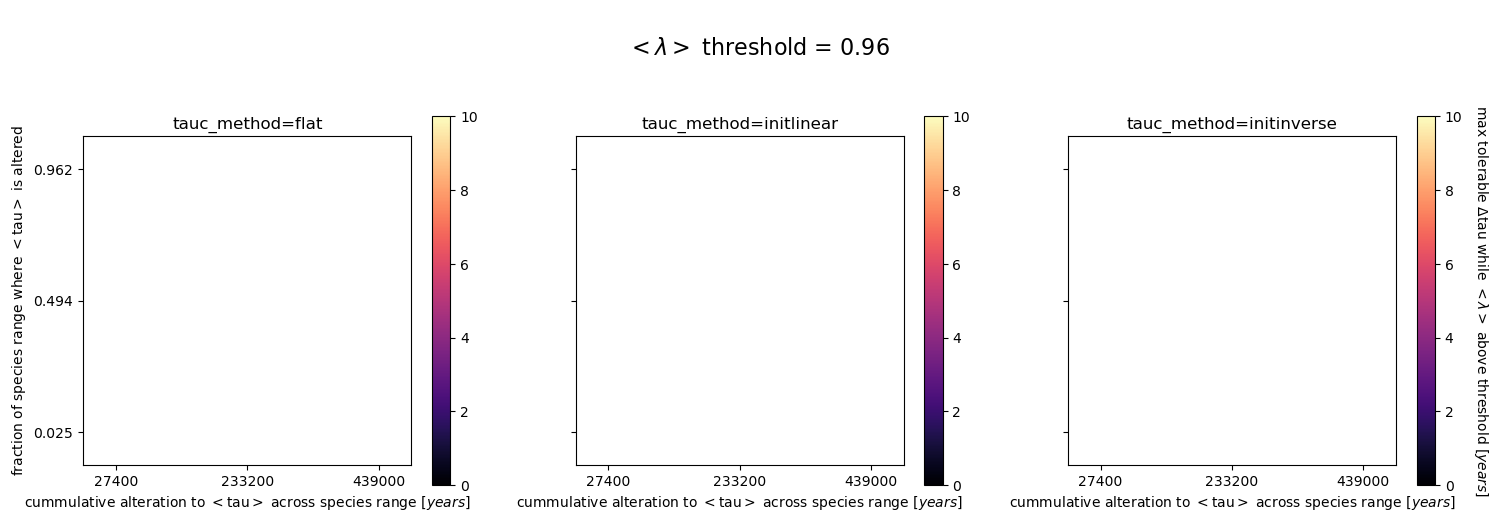

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
# cmap = copy.copy(matplotlib.cm.jet_r)
cmap = copy.copy(matplotlib.cm.magma)
vmax = max(robustness_all.flatten())
im1 = axes[0].imshow(np.flip(robustness_all[0][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
cbar = axes[0].figure.colorbar(im1, ax=axes[0], location="right", shrink=0.8)
im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
im2 = axes[1].imshow(np.flip(robustness_all[1][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
cbar = axes[1].figure.colorbar(im2, ax=axes[1], location="right", shrink=0.8)
im2.axes.set_title(f"tauc_method={tauc_methods[1]}")
im3 = axes[2].imshow(np.flip(robustness_all[2][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
cbar = axes[2].figure.colorbar(im3, ax=axes[2], location="right", shrink=0.8)
im3.axes.set_title(f"tauc_method={tauc_methods[2]}")
cbar.set_label(r'max tolerable $\Delta{\text{tau}}$ while $<\lambda>$ above threshold [$years$]', 
               rotation=-90, fontsize=10, labelpad=20)

def update(frame):
    for im_i, im in enumerate([im1, im2, im3]):
        im.set_array(np.flip(robustness_all[im_i][frame], axis=0))
        # im.axes.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[frame], 3)}")
        # axes[im_i].set_aspect(0.4)
        ytick_spacing = 2
        yticks = np.arange(0,len(ncell_vec),ytick_spacing)
        if im_i == 0:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
            im.axes.set_ylabel(r'fraction of species range where $<\text{tau}>$ is altered')
        else:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=[]);
        xtick_spacing = 2
        xticks = np.arange(0,len(C_vec),xtick_spacing)
        im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
        im.axes.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]')
        # axes[im_i].set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[thresh_i], 3)}")
    fig.suptitle(f"\n$<\lambda>$ threshold = {np.round(thresh_vec_rob[frame], 3)}", fontsize=16)
    return [im1, im2, im3]

ani = animation.FuncAnimation(
    fig, update, frames=len(thresh_vec_rob), blit=True, interval=100  # interval is time between frames in milliseconds
)
anifn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/robustness.mp4"
ani.save(anifn, writer='ffmpeg', fps=10)

Make similar viz but put delta_tau threshold on slider and color by max($<\lambda>$), with max taken over $\tau_i$. At each $\tau_i$, take the min($<\lambda>$) while $|\Delta{\tau}| <= threshold$ is satisfied. So, color by the 'best-worst' case scenario for $<\lambda>$ under a given $|\Delta{\tau}|$ threshold (aka "horizon of uncertainty" in info-gap). 

Implicit assumption here is that min$(<\lambda>(C,n_{cell},\tau_i))$ decreases monotonically with increasing $|\Delta{\tau}|$ threshold, which is fairly safe, but might want to look into that more. 

In [5]:
'''
thresh_vec = delta_tau_vec[delta_tau_vec >= 0]
for delta_tau thresh
    for i,j in (C, ncell):
        phase_slice = full_phase[:, j, i, :]
        for slice_left:
            delta_tau_filt = (delta_tau_vec >= -thresh) & (delta_tau_vec <= thresh)
            within_thresh = phase_slice[delta_tau_filt, sl_i]
            max(within_thresh)
            store max
        keep max over all slice_left
'''

'\nthresh_vec = delta_tau_vec[delta_tau_vec >= 0]\nfor delta_tau thresh\n    for i,j in (C, ncell):\n        phase_slice = full_phase[:, j, i, :]\n        for slice_left:\n            delta_tau_filt = (delta_tau_vec >= -thresh) & (delta_tau_vec <= thresh)\n            within_thresh = phase_slice[delta_tau_filt, sl_i]\n            max(within_thresh)\n            store max\n        keep max over all slice_left\n'

In [10]:
delta_zero_i = np.nonzero(delta_tau_vec == 0)[0][0]
delta_tau_step = np.unique(np.diff(delta_tau_vec))[0]
thresh_vec_maxlam = delta_tau_vec[delta_tau_vec >= 0]
# Initialize data for the max(<lam>) per (C, ncell, threshold) combination
maxlam_all = np.ones((len(tauc_methods), len(thresh_vec_maxlam), len(ncell_vec), len(C_vec))) * np.nan
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    full_phase = np.load(fn_prefix + f"/metric_{metric}/phase_{tauc_method}.npy")
    nochange_all = np.ones_like(thresh_vec_maxlam) * np.nan
    all_maxes = np.ones_like(thresh_vec_maxlam) * np.nan
    for thresh_i, thresh in enumerate(thresh_vec_maxlam):
        maxlam = np.ones((len(ncell_vec), len(C_vec))) * np.nan
        for i, j in itertools.product(range(maxlam.shape[0]), range(maxlam.shape[1])):
            # Take slice of full_phase at (C, ncell) with axes (delta_tau, tau_i)
            phase_slice = full_phase[:, j, i, :]
            # Create filter for delta_tau axis
            delta_tau_filt = (delta_tau_vec >= -thresh) & (delta_tau_vec <= thresh)
            minlam_per_sl = np.ones_like(slice_left_all)*np.nan
            for sl_i, slice_left in enumerate(slice_left_all):
            # for sl_i, slice_left in enumerate(slice_left_all[40:41]):
                within_thresh = phase_slice[delta_tau_filt, sl_i]
                # Check that <lam> was computed for this (C,ncell,tau_i)
                if np.all(np.isnan(within_thresh)): continue
                # Take the worst case scenario (i.e. min(<lam>)) within uncertainty threshold
                minlam_per_sl[sl_i] = np.nanmin(within_thresh)
            # Now store the best possible lower bound on <lam>
            # Keep at nan if no <lam> computed at this (C,ncell) (this shouldn't happen)
            if np.any(~np.isnan(minlam_per_sl)):
                maxlam[i,j] = np.nanmax(minlam_per_sl)
            else:
                print(f"hey, no samples at C={C_vec[i]}, ncell={ncell_vec[j]}")
        maxlam_all[tauc_method_i, thresh_i] = maxlam

        # Also store nochange value
        mindelta_i = np.nonzero(delta_tau_vec == -thresh)[0][0]
        nochangefn = fn_prefix+f"metric_{metric}/deltatau_{delta_tau_vec[mindelta_i]}/nochange_{tauc_method}.json"
        with open(nochangefn, 'r') as handle:
            nochange = json.load(handle)['lambda_s_expect_nochange']
        nochange_all[thresh_i] = nochange

        # Pre-process the maximum's per threshold for plotting as well
        all_maxes[thresh_i] = np.nanmax(maxlam.flatten())

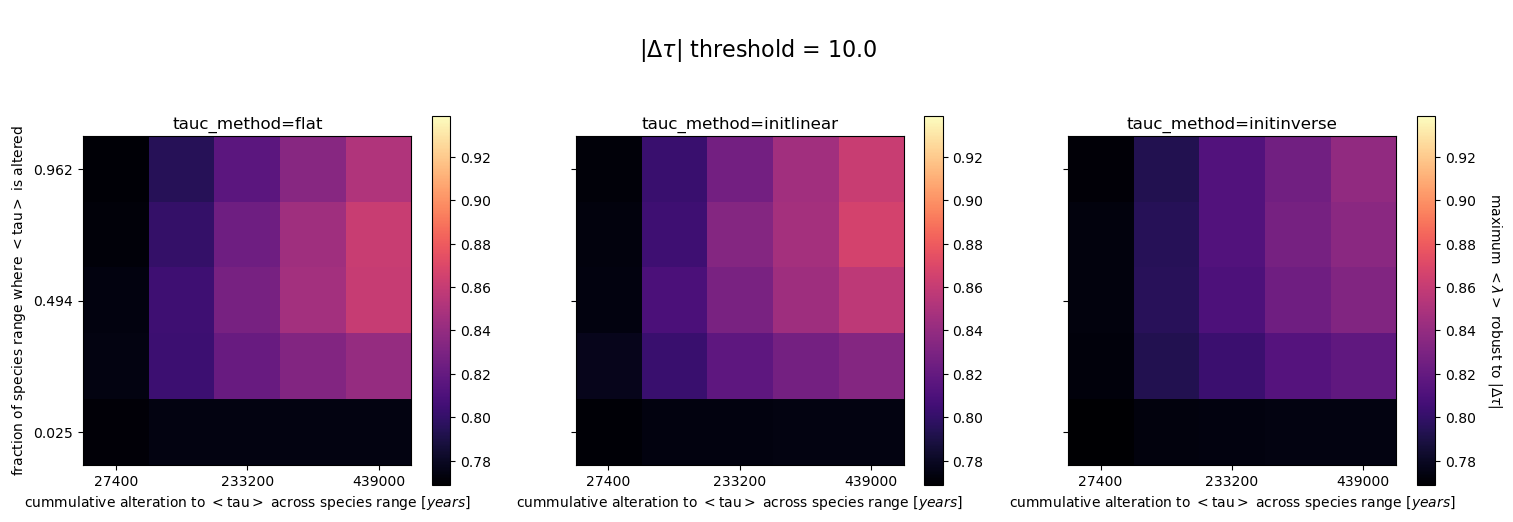

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
cmap = copy.copy(matplotlib.cm.magma)
vmax = np.nanmax(maxlam_all.flatten())
vmin = np.nanmin(maxlam_all.flatten())
im1 = axes[0].imshow(np.flip(maxlam_all[0][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = axes[0].figure.colorbar(im1, ax=axes[0], location="right", shrink=0.8)
im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
im2 = axes[1].imshow(np.flip(maxlam_all[1][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = axes[1].figure.colorbar(im2, ax=axes[1], location="right", shrink=0.8)
im2.axes.set_title(f"tauc_method={tauc_methods[1]}")
im3 = axes[2].imshow(np.flip(maxlam_all[2][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = axes[2].figure.colorbar(im3, ax=axes[2], location="right", shrink=0.8)
im3.axes.set_title(f"tauc_method={tauc_methods[2]}")
cbar.set_label(r"maximum $<\lambda>$ robust to $|\Delta\tau|$", rotation=-90, fontsize=10, labelpad=20)

def update(frame):
    for im_i, im in enumerate([im1, im2, im3]):
        im.set_array(np.flip(maxlam_all[im_i][frame], axis=0))
        # im.axes.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[frame], 3)}")
        # axes[im_i].set_aspect(0.4)
        ytick_spacing = 2
        yticks = np.arange(0,len(ncell_vec),ytick_spacing)
        if im_i == 0:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
            im.axes.set_ylabel(r'fraction of species range where $<\text{tau}>$ is altered')
        else:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=[]);
        xtick_spacing = 2
        xticks = np.arange(0,len(C_vec),xtick_spacing)
        im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
        im.axes.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]')
        # axes[im_i].set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[thresh_i], 3)}")
    fig.suptitle("\n" + r"$|\Delta\tau|$ threshold = " + f"{np.round(thresh_vec_maxlam[frame], 3)}", fontsize=16)
    return [im1, im2, im3]

ani = animation.FuncAnimation(
    fig, update, frames=len(thresh_vec_maxlam), blit=True, interval=100  # interval is time between frames in milliseconds
)
anifn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxlam.mp4"
ani.save(anifn, writer='ffmpeg', fps=10)

### Checking results relative to nochange

In [ ]:
plt.hist(full_phase.flatten(), bins=50);
plt.axvline(min(nochange_all), ls='--', c='k')

In [ ]:
axis_labels = ["delta_tau", "C", "ncell", "tau_i"]
problem_indicies = np.argwhere(full_phase < min(nochange_all))
# for pi in problem_indicies:
#     print(pi)
# Where are these problems happening most often? Check each dimension
for axis in range(problem_indicies.shape[-1]):
    plt.hist(problem_indicies[:, axis])
    plt.title(axis_labels[axis])
    plt.show()

In [ ]:
delta_tau_filt = np.nonzero((problem_indicies[:,0] == 0) #delta_tau
                            & (problem_indicies[:,1] == 4) #C
                            & (problem_indicies[:,2] == 12) #ncell
                            # & (problem_indicies[:,3] == 82) #slice_left_i
                            )[0]
plt.hist(problem_indicies[delta_tau_filt,3]);

In [ ]:
tau_max_all = np.load(fn_prefix+"tau_max_all.npy")
delta_tau = -10.0
for C in C_vec:
    # C = C_vec[4]
    nochangefn = fn_prefix+f"deltatau_{delta_tau}/const_{C}/metric_lambda_s/nochange.json"
    print(nochangefn)
    with open(nochangefn, 'r') as handle:
        nochange = json.load(handle)['lambda_s_expect_nochange']
    phasefn = fn_prefix+f"deltatau_{delta_tau}/const_{C}/metric_lambda_s/phase_scaledtoinit.npy"
    phase_space = np.load(phasefn)
    metric='lambda_s'
    fig, ax = plt.subplots(figsize=(12,12))
    phase_space = np.ma.masked_where(np.isnan(phase_space),  phase_space)
    phase_flat = phase_space.flatten()
    cmap = copy.copy(matplotlib.cm.plasma)
    if len(phase_flat[phase_flat != np.ma.masked]) == 0:
        phase_max = 0
    else:
        '''doing this for now bc some runs are bad'''
        if (metric=='r') or (metric=='g'):
            phase_max = np.quantile(phase_flat[phase_flat != np.ma.masked], 0.98)
        if metric in ['Nf', 'xs', 'mu_s', 'lambda_s']:
            phase_max = max(phase_flat[phase_flat != np.ma.masked])
            phase_min = min(phase_flat[phase_flat != np.ma.masked])
    cmap.set_bad('white')
    im = ax.imshow(phase_space, norm=matplotlib.colors.Normalize(vmin=phase_min, vmax=phase_max), cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
    cbar.ax.set_ylabel(r'$<{}>$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
    cbar.ax.axhline(nochange, color='white', linewidth=2)

### Using interact

In [ ]:
def plt_robustness(thresh_i=0):
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = copy.copy(matplotlib.cm.jet_r)
    # cmap = copy.copy(matplotlib.cm.cool_r)
    # cmap = copy.copy(matplotlib.cm.plasma)
    vmax = max(robustness_all.flatten())
    im = ax.imshow(np.flip(robustness_all[thresh_i], axis=0), cmap=cmap, vmin=0, vmax=vmax)
    ax.set_aspect(0.4)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.7)
    cbar.set_label(r'max tolerable $\Delta{\text{tau}}$ while $<\lambda>$ above threshold [$years$]', rotation=-90, fontsize=10, labelpad=20)
    # ytick_spacing = 2
    # ytick_labels = np.round(np.flip(alteration_areas)[::ytick_spacing]).astype(int)
    # yticks = np.arange(0,len(alteration_areas),ytick_spacing)
    # ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    # ax.set_ylabel(r'geographic area where $<\text{tau}>$ is altered [$km^2$]')
    ytick_spacing = 2
    ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
    yticks = np.arange(0,len(ncell_vec),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel(r'fraction of species range where $<\text{tau}>$ is altered')
    xtick_spacing = 1
    xticks = np.arange(0,len(C_vec),xtick_spacing)
    ax.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
    ax.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]')
    ax.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[thresh_i], 3)}")
    
interact(plt_robustness, thresh_i=(0, len(thresh_vec_rob)-1, 1))

### Looking at max(<$\lambda$>) across $\tau_i$

In [ ]:
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/delta_fri_phase_{fric_method}.npy"
# fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/scaledfric_delta_fri_phase.npy"
data = np.load(fn)
print(data.shape)
print("(constraint, n_cell, delta_fri)")

In [ ]:
metric = 'lambda_s'
for i in range(data.shape[2]):
    if delta_fri_vec[i] != 0: continue
    fig, ax = plt.subplots(figsize=(5,5))#(10,14))
    cmap = copy.copy(matplotlib.cm.plasma)
    data_slice = np.swapaxes(data[:, :, i], 0, 1)
    im = ax.imshow(np.flip(data_slice, 0), cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.5)
    cbar.ax.set_ylabel(r'$max(<\{}>)$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
    ytick_spacing = 2
    ytick_labels = np.flip(ncell_vec)[::ytick_spacing]
    yticks = np.arange(0,len(ncell_vec),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel('Number of cells intervened in')
    xtick_spacing = 3
    xticks = np.arange(0,len(constraint_vec),xtick_spacing)
    ax.set_xticks(xticks, labels=np.round(constraint_vec[::xtick_spacing]));
    ax.set_xlabel('C, total fri change across species range')
    ax.set_title(f'delta_fri={delta_fri_vec[i]}')
    # fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/phase_{metric}_deltafri{delta_fri_sys[i]}.png"
    # fig.savefig(fn, bbox_inches='tight')

In [ ]:
# threshold = 0
# threshold_vec = np.arange(-0.5, 0.75, 0.05)
# threshold_vec = np.arange(-0.04, 0.001, 0.001)
dmin, dmax = (min(data.flatten()), max(data.flatten()))
# dmin, dmax = (0.76, 0.978)
threshstep = (dmax - dmin) / 50
threshold_vec = np.arange(dmin, dmax+threshstep, threshstep)
# z = np.empty((data.shape[0], len(threshold_vec)))
z = np.empty((len(threshold_vec), data.shape[0]))
x, y = np.meshgrid(constraint_vec, threshold_vec)
for thresh_i, threshold in enumerate(threshold_vec):
    Delta_vec = np.empty(data.shape[:-1])
    for const_i in range(data.shape[0]):
        for n_cell_i in range(data.shape[1]):
            # For computing with systematic errors 
            above_thresh_counts = np.count_nonzero(data[const_i, n_cell_i, :] > threshold)
            Delta_fri = above_thresh_counts * (delta_fri_vec[1] - delta_fri_vec[0])
            Delta_vec[const_i, n_cell_i] = Delta_fri
            # For computing with normally distributed errors
            # try:
            #     max_sigma_i = max(np.nonzero(data[const_i, n_cell_i, :] > threshold)[0])
            # except:
            #     max_sigma_i = 0
            # Delta_vec[const_i, n_cell_i] = delta_fri_vec[max_sigma_i]
    # Store the max tolerated uncertainty at each constraint value
    z[thresh_i, :] = np.max(Delta_vec, axis=1)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
fig, ax = plt.subplots(figsize=(8,10))
cmap = copy.copy(matplotlib.cm.jet_r)
im = ax.imshow(np.flip(z, axis=0), cmap=cmap)#, vmin=3, vmax=7)
ax.set_aspect(0.1)
# im = ax.imshow(z, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.5)
cbar.ax.set_ylabel(r'$\Delta{fri}$', rotation=-90, fontsize=10, labelpad=20)
# cbar.ax.set_ylabel(r'$max(\sigma)$', rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 4
ytick_labels = np.flip(threshold_vec)[::ytick_spacing]
yticks = np.arange(0,len(threshold_vec),ytick_spacing)
ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
ax.set_ylabel(f'max(<{metric}>) threshold')
xtick_spacing = 1
xticks = np.arange(0,len(constraint_vec),xtick_spacing)
ax.set_xticks(xticks, labels=constraint_vec[::xtick_spacing]);
ax.set_xlabel('C, total fri change across species range')
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/deltafri_phase_{metric}.png"
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/deltafri_random_phase_{metric}.png"
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/scaledfric_deltafri_phase_{metric}.png"
# fig.savefig(fn, bbox_inches='tight')

In [ ]:
# %matplotlib widget

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, z, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('max(<r>) threshold')
ax.set_xlabel('area where <fif>=1')
ax.set_zlabel(r'$\Delta{fri}$')

## Sketching inverse scaling of tauc with k

ncell=5000,C=80000
Optimal solution: v = 562.6912974903553, w = 26.898766808528027
Objective value at the optimum: 68756.46312209383
max tau_star linear scaling 32.0
approximate integral of tauc_k w/ optimal values 79448.54069630957


/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_32545/1166648004.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  Tstar = v*w*np.log((ncell/(2*w)) + 1)
/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_32545/1166648004.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  Tstar = v*w*np.log((ncell/(2*w)) + 1)
/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_32545/1166648004.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  Tstar = v*w*np.log((ncell/w) + 1)
/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_32545/1166648004.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  Tstar = v*w*np.log((ncell/w) + 1)


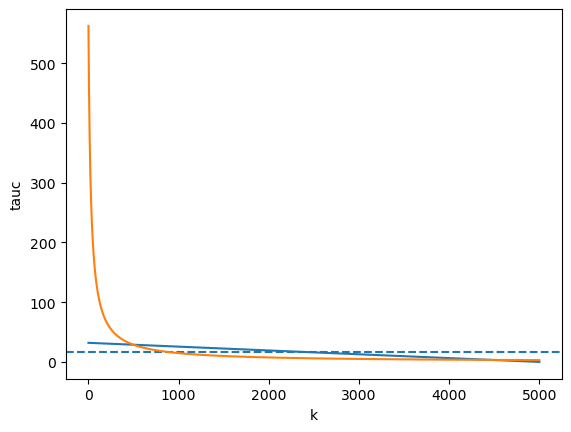

ncell=5000,C=164600
Optimal solution: v = 1124.8406621165818, w = 27.803941682729242
Objective value at the optimum: 141048.02951696122
max tau_star linear scaling 65.84
approximate integral of tauc_k w/ optimal values 163116.415944269


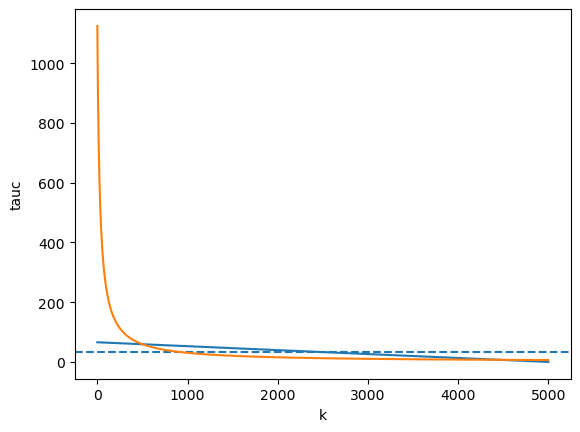

ncell=5000,C=320000
Optimal solution: v = 3650.7519872291787, w = 14.885019561393522
Objective value at the optimum: 278751.70423818735
max tau_star linear scaling 128.0
approximate integral of tauc_k w/ optimal values 318097.70335698326


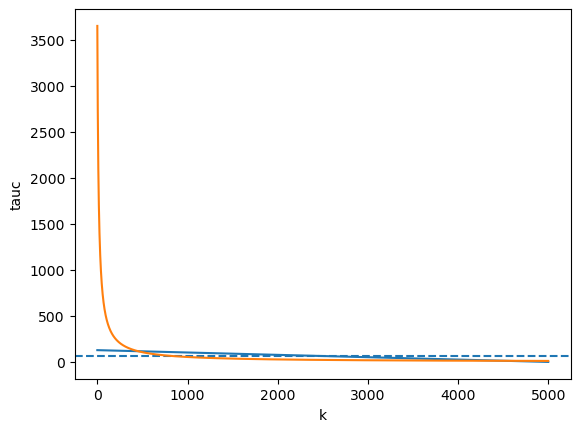

ncell=15000,C=80000
Optimal solution: v = 248.54249973629027, w = 57.51785151484325
Objective value at the optimum: 69736.98416674932
max tau_star linear scaling 10.666666666666666
approximate integral of tauc_k w/ optimal values 79715.613331182


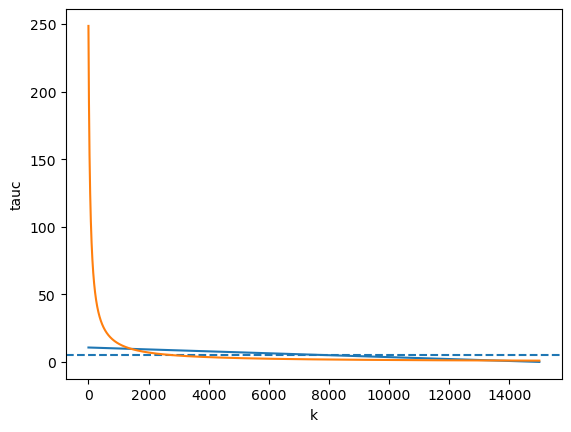

ncell=15000,C=164600
Optimal solution: v = 410.7473772354423, w = 74.79034624514266
Objective value at the optimum: 141861.36274325632
max tau_star linear scaling 21.946666666666665
approximate integral of tauc_k w/ optimal values 163207.58039080273


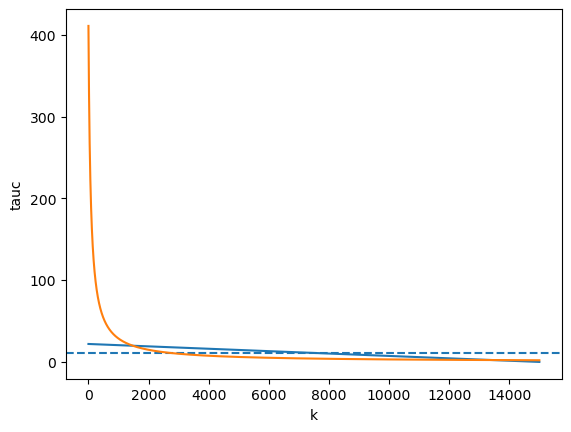

ncell=15000,C=320000
Optimal solution: v = 712.2413759281335, w = 85.96558242158805
Objective value at the optimum: 274309.159558391
max tau_star linear scaling 42.666666666666664
approximate integral of tauc_k w/ optimal values 316756.2149747059


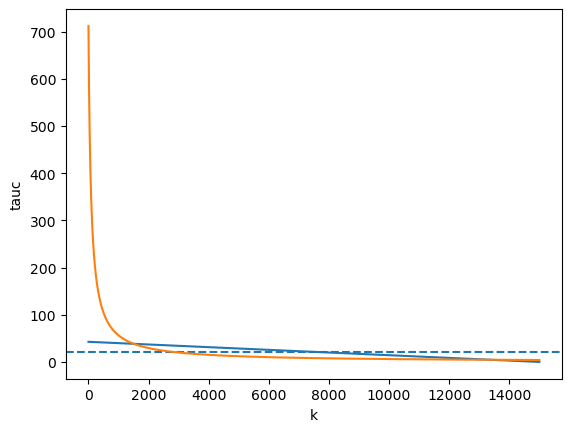

ncell=30000,C=80000
Optimal solution: v = 165.0319714477287, w = 81.70900294896092
Objective value at the optimum: 70363.62634044001
max tau_star linear scaling 5.333333333333333
approximate integral of tauc_k w/ optimal values 79756.31978953758


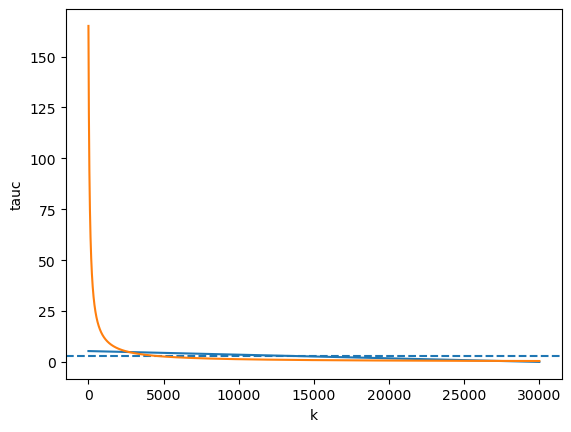

ncell=30000,C=164600
Optimal solution: v = 245.99660589580353, w = 120.3928489723163
Objective value at the optimum: 143136.4199973192
max tau_star linear scaling 10.973333333333333
approximate integral of tauc_k w/ optimal values 163669.3630630113


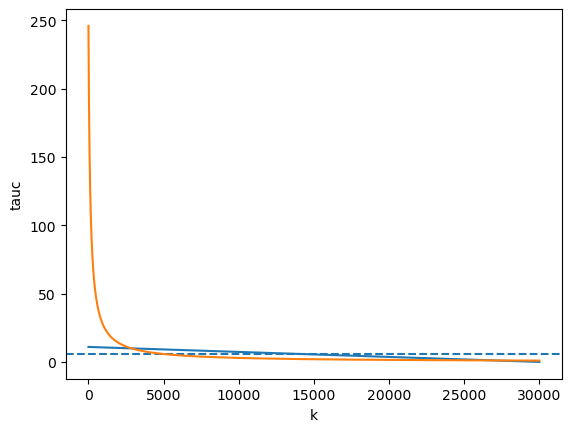

ncell=30000,C=320000
Optimal solution: v = 402.69245164589023, w = 148.13766771590645
Objective value at the optimum: 276047.9716229667
max tau_star linear scaling 21.333333333333332
approximate integral of tauc_k w/ optimal values 317305.10066475853


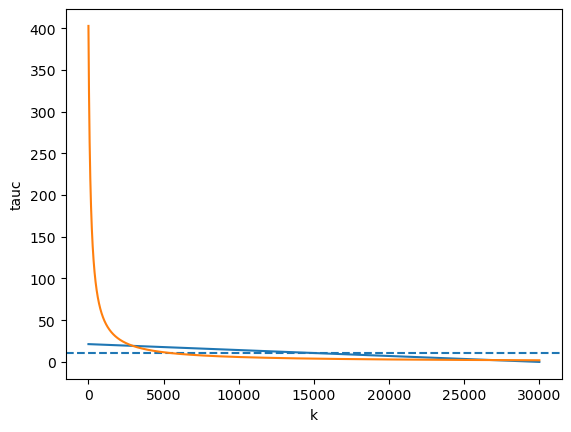

ncell=70000,C=80000
Optimal solution: v = 148.19271482895616, w = 79.23272446984913
Objective value at the optimum: 71541.96300808173
max tau_star linear scaling 2.2857142857142856
approximate integral of tauc_k w/ optimal values 79741.59852146306


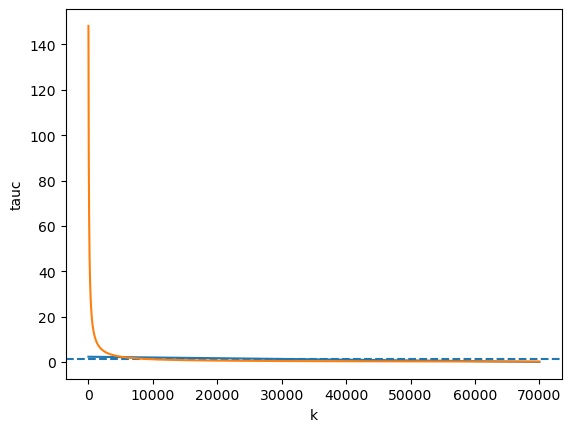

ncell=70000,C=164600
Optimal solution: v = 173.7724568494996, w = 154.20558352268677
Objective value at the optimum: 145484.89671969638
max tau_star linear scaling 4.702857142857143
approximate integral of tauc_k w/ optimal values 164086.89421097032


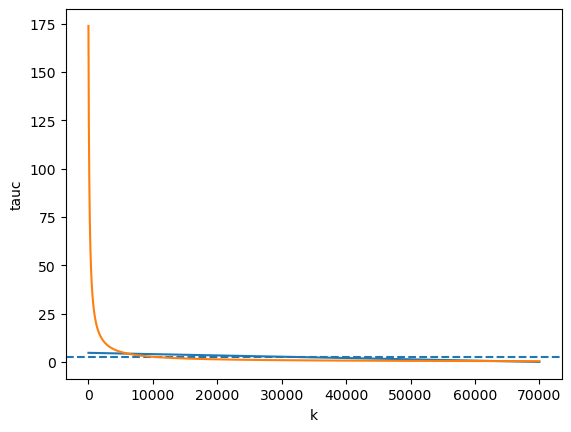

ncell=70000,C=320000
Optimal solution: v = 229.83702009159956, w = 244.33134768911285
Objective value at the optimum: 279183.43566273135
max tau_star linear scaling 9.142857142857142
approximate integral of tauc_k w/ optimal values 318027.68521640747


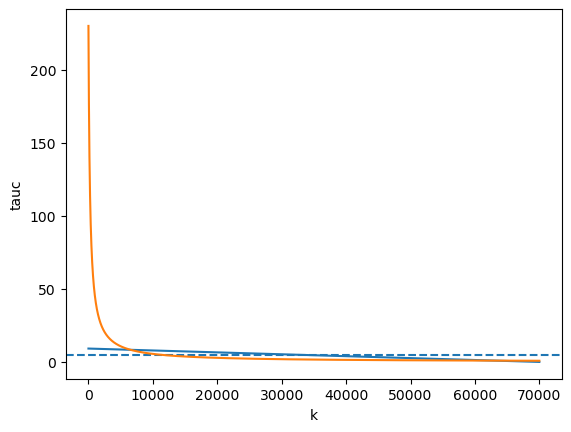

In [14]:
for ncell, C in itertools.product([5_000, 15_000, 30_000, 70_000],
                                   [80_000, 164_600, 320_000]):
    print(f"ncell={ncell},C={C}")
    # Integral up to the midpoint, i.e. of the lower tau end
    def Tstar_pre_midpoint(vars):
        v, w = vars
        Tstar = v*w*np.log((ncell/(2*w)) + 1)
        # Multiply by -1 bc we want max, not min
        return -1 * Tstar
    # Total integral needs to be eq to C
    def Tstar_ncell(vars):
        v, w = vars
        Tstar = v*w*np.log((ncell/w) + 1)
        return Tstar - C
    # Set the initial guess
    initial_guess = [40, 0.1]
    # Define the constraint as a dictionary (equality constraint)
    con = {'type': 'eq', 'fun': Tstar_ncell}
    # Use the minimize function with the 'SLSQP' method
    result = scipy.optimize.minimize(Tstar_pre_midpoint, initial_guess, method='SLSQP', constraints=[con], 
                      bounds=[(0,1e30), (0,1e30)])
    # Print the results
    optimal_v, optimal_w = result.x
    print(f"Optimal solution: v = {optimal_v}, w = {optimal_w}")
    print(f"Objective value at the optimum: {-result.fun}")  # Negate to get the actual maximum
    
    k_vec = np.arange(0,ncell)
    min_linear_v = -(2*C) / (ncell**2)
    print('max tau_star linear scaling', 2*C/ncell)
    print("approximate integral of tauc_k w/ optimal values", sum(optimal_v / ((k_vec/optimal_w) + 1)))
    plt.axhline(C/ncell, ls='--')
    plt.plot(k_vec, min_linear_v*k_vec + (2*C/ncell))
    plt.plot(k_vec, optimal_v / ((k_vec/optimal_w) + 1))
    plt.xlabel('k')
    plt.ylabel('tauc')
    plt.show()

## Sketching out tauc scaling with initial tau

In [ ]:
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
t_final = 600
fri_vec = b_vec * gamma(1+1/c)
final_max_fri = max(fri_vec)
min_fri = 3
Aeff = 7.29
A_cell = 270**2 / 1e6 #km^2
baseline_areas = np.arange(10, 160, 30)
ncell_baseline_max = round(max(baseline_areas)/A_cell)
ncell_step = 6_500

ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()

In [ ]:
# Generate slices of the fri distribution used at all delta_fri
fri_argsort = np.argsort(fri_flat)
# Use the max post alteration fri to get an upper bound on right hand of slices
fri_sorted = fri_flat[fri_argsort] 
if max(fri_sorted) > final_max_fri:
    slice_right_max = min(np.nonzero(fri_sorted >= final_max_fri)[0])
else:
    slice_right_max = len(fri_sorted) - 1
'''If I force the fri distribution minimum to be min_fri, do I need to
   define slice_left_min? Won't it always be 0?'''
slice_left_min = np.nonzero(fri_sorted > min_fri)[0][0]
'''add step to endpoint? s.t. max possible ncell is included'''
ncell_vec = np.arange(ncell_baseline_max, slice_right_max, ncell_step)
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/"
constraint_vec = np.load(fn_prefix + "constraint_vec.npy")
slice_spacing = 500
# print((slice_right_max - min(ncell_vec)) - slice_left_min)
slice_left_max = slice_right_max - min(ncell_vec)
slice_left_all = np.arange(slice_left_min, slice_left_max, slice_spacing)
# print(slice_left_all)
fri_max_all = np.ones((len(constraint_vec), len(ncell_vec), len(slice_left_all))) * np.nan
for constraint_i, constraint in enumerate(constraint_vec):
# for constraint in constraint_vec[3:4]:
    # for ncell in ncell_vec[12:13]:
    for ncell_i, ncell in enumerate(ncell_vec):
        # print(constraint/ncell)
        # Store indicies of a bunch of slices, or just the starting point and reference indices from argsort
        # Use a constant spacing between slice samples, higher ncells will have less samples as desired
        slice_left_max = slice_right_max - ncell #slice needs to fit
        # for slice_left in slice_left_all[20:21]:
        # for slice_left in slice_left_all[14:15]:
        for sl_i, slice_left in enumerate(slice_left_all):
            if slice_left > slice_left_max: continue
            # Solve for tau_max which makes sum(tau_star)=C
            '''Solve for these tau_max at every (C, ncell) for delta_fri=0, then reuse for delta_fri > 0'''
            fri_slice = fri_sorted[slice_left:slice_left+ncell]
            def C_diff(fri_max):
                # rhs = ncell*fri_max - np.sum(np.where(fri_slice < fri_max, fri_slice, 0))
                fric_slice = fri_max - fri_slice
                fric_slice = np.where(fri_slice < fri_max, fric_slice, 0)
                return np.abs(constraint - np.sum(fric_slice))
            # diffmin = scipy.optimize.minimize_scalar(C_diff)
            diffmin = scipy.optimize.minimize_scalar(C_diff, bounds=(constraint/ncell, 1e5))
            # print(slice_left, diffmin.x)
            fri_max_all[constraint_i, ncell_i, sl_i] = diffmin.x

In [ ]:
plt.hist(fri_max_all.flatten(), bins=50);

In [ ]:
A_cell = 270**2 / 1e6 #km^2
baseline_area = 130
ncell_baseline = round(baseline_area/A_cell)
fric_baseline = 200
ncell_baseline * fric_baseline

In [ ]:
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()
tau_argsort = np.argsort(fri_flat)
tau_sorted = fri_flat[tau_argsort]

In [ ]:
'''
get tau_i distribution
for each ncell
    get bounds on values for tau_max
    if min(tau_bounds) > max(tau_vec): continue?
    for samples between [min(tau_bounds), min([max(tau_bounds), max(tau_vec)])]:
        compute sum of (tau_max - tau_slice) for all slices of length ncell in between slice_left_min and slice_left_max
        for sum with minimal difference from C, compute <metric>
'''
C = 356_600
# C = 27_400
tau_max = 220
tau_min = 2
# ncell = 1783
ncell = 6_783
# ncell = 40_783
# ncell = 79_783
nearC_thresh = 0.05
slice_left_max = len(tau_sorted) - ncell
slice_left_min = np.nonzero(tau_sorted > tau_min)[0][0]

# First find t_max where slice with lowest initial tau satisfies C
# This gives us a lower bound on t_max which can satisfy C
# Then find t_max where slice with highest initial tau satisfies C
# This gives us an upper bound on t_max which can satisfy C
tau_max_bounds = []
tau_max = C / ncell #starting value for the scan
for lb in [slice_left_min, slice_left_max]:
    tau_slice = tau_sorted[lb:lb+ncell]
    bound_located = False
    while not bound_located:
        check = np.sum(tau_max - tau_slice)
        # if np.abs(check-C) <= nearC_thresh*C:
        if check >= C:
            bound_located = True
        else:
            tau_max += 0.1
    tau_max_bounds.append(tau_max)
print(tau_max_bounds)

tau_max_vec = np.linspace(min(tau_max_bounds), max(tau_max_bounds), 20)
for tau_max in tau_max_vec:
    '''https://stackoverflow.com/questions/38507672/summing-elements-in-a-sliding-window-numpy'''
    start = time.process_time()
    sums = scipy.signal.fftconvolve((tau_max - tau_sorted[slice_left_min:]),np.ones(ncell,dtype=int),'valid')
    print(time.process_time() - start)
    plt.hist(sums, bins=100)
    plt.xlabel("sum of (tau_max - tau_slice)")
    plt.ylabel("number of left bound starting points")
    plt.axvline(C, ls='--', c='k')
    plt.show()
    '''Lower maximum shift in tau allows for many possible slices from the initial tau distribution
       higher max shift restricts the number of possible slices'''
    diffs = np.abs(sums - C)
    print(f"tau_max={tau_max}")
    print(np.count_nonzero(diffs < C*nearC_thresh) / (slice_left_max - slice_left_min))
    closest_i = np.argmin(diffs)
    print(tau_sorted[closest_i]) #Starting point for slice that minimizes difference to C
    print(np.mean(tau_sorted[closest_i:closest_i+ncell]))

## Visualize fric across C values

In [ ]:
A_cell = 270**2 / 1e6 #km^2
fric_baseline = 800 #years, max fire return interval change possible 
                    #at lowest n_cell for a given C value
# A_baseline = 200
A_baselines = np.arange(10, 210, 30)
for A_baseline in A_baselines:
    C = (A_baseline / A_cell) * fric_baseline
    max_n_cell = 80_000
    # print(C, C/max_n_cell)
    n_cell_step = 1_000
    n_cell_vec = np.arange(2_000, max_n_cell+n_cell_step, n_cell_step)
    fric_vec = C / n_cell_vec
    plt.scatter(n_cell_vec, fric_vec)
    plt.ylim(0,100)
# plt.show()
# plt.scatter(n_cell_vec, fric_vec)
# plt.ylim(0,100)
# plt.show()

## Re-vizualize metric hist

In [ ]:
Aeff = 7.29; t_final = 600; c=1.42
metric = 'lambda_s'
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_data.pkl"
with open(fn, 'rb') as handle:
    metric_data = pickle.load(handle)
all_metric = metric_data[metric]['all_metric']
# all_metric = np.exp(metric_data[metric]['all_metric'])
metric_thresh = 0.98
metric_bw_ratio = 50
metric_min, metric_max = (np.quantile(all_metric, 1-metric_thresh), np.quantile(all_metric, metric_thresh))
metric_bw = (metric_max - metric_min) / metric_bw_ratio
# metric_bw = 0.02
metric_edges = np.arange(metric_min, metric_max + metric_bw, metric_bw)

with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/all_fri.npy"
all_fri = np.load(fn)
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))

In [ ]:
coarse_step = 0.02
fine_step = coarse_step/100
fine_start = 0.9
coarse_grained = np.arange(metric_min, fine_start, coarse_step)
fine_grained = np.arange(fine_start, metric_max + fine_step, fine_step)
metric_edges = np.concatenate((coarse_grained[:-1], fine_grained))

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
'''If we use unequal metric bin widths, need to set density=True'''
'''Why not just always set density=True?'''
metric_hist = ax.hist2d(all_fri, all_metric, bins=[fri_edges, metric_edges], 
                 norm=matplotlib.colors.LogNorm(vmax=int(len(all_metric)/len(b_vec))), 
                # norm=matplotlib.colors.LogNorm(vmax=0.0682899627411097),
                        density=False)
cbar = ax.figure.colorbar(metric_hist[-1], ax=ax, location="right")
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ax.set_xlabel('<FRI>')
ax.set_ylim(0.8,1)

## Test \<metric> calculation

In [ ]:
Aeff=7.29
t_final = 600
metric = 'lambda_s'
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_data.pkl"
with open(fn, 'rb') as handle:
    metric_data = pickle.load(handle)
all_metric = metric_data[metric]['all_metric']
metric_hist = metric_data[metric]['metric_hist']
metric_thresh = 0.98
metric_bw_ratio = 50
metric_min, metric_max = (np.quantile(all_metric, 1-metric_thresh), np.quantile(all_metric, metric_thresh))
coarse_step = 0.02
fine_step = coarse_step/100
fine_start = 0.6
coarse_grained = np.arange(metric_min, fine_start, coarse_step)
fine_grained = np.arange(fine_start, metric_max + fine_step, fine_step)
metric_edges = np.concatenate((coarse_grained[:-1], fine_grained))
metric_vals = []
diffs = np.diff(metric_edges)
# bw_ratio = 1000
# for edge_i, edge in enumerate(metric_edges[:-1]):
#     dm = diffs[edge_i] / bw_ratio
#     metric_vals.append(list(np.arange(edge, metric_edges[edge_i+1]+dm, dm)))
# metric_vals = np.array(list(itertools.chain.from_iterable(metric_vals)))
for edge_i, edge in enumerate(metric_edges[:-1]):
    metric_vals.append(edge + diffs[edge_i]/2) 
metric_vals = np.array(metric_vals)

fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/all_fri.npy"
all_fri = np.load(fn)
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
dfri = 0.01
metric_hist = np.histogram2d(all_fri, all_metric, bins=[fri_edges, metric_edges], 
                        density=True)
# Read in fixed fire map 
fdmfn = '../shared_maps/FDE_current_allregions.asc'
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()

test_vec = []
# delta_test_vec = [-17, 0, 10, 15, 20, 30, 40, 50, 55, 70, 80, 90]
# for delta_fri in delta_test_vec:
baseline_areas = np.arange(10, 150, 10)
for baseline_area in baseline_areas:
    n_cell_baseline = round(baseline_area/A_cell)
    fif_baseline = 1
    constraint = n_cell_baseline * fif_baseline
    n_cell = 42_058
    fif = constraint / n_cell
    fire_freqs = 1 / fri_flat
    freq_argsort = np.argsort(fire_freqs)
    fire_freqs_sorted = fire_freqs[freq_argsort]
    max_fri = 66
    slice_left_min = np.nonzero(fire_freqs_sorted > (1/max_fri))[0][0]
    # freq_left = freq_left_samples_sub[fif_i][sub_sample_i]
    # slice_left = np.nonzero(fire_freqs_sorted > freq_left)[0][0]
    slice_left = int(len(fri_flat)/2) - int(n_cell/2)
    fire_freq_slice = fire_freqs_sorted[slice_left:slice_left+n_cell]
    max_fif = fire_freq_slice - fire_freqs_sorted[slice_left_min]
    # First create array of replacement frequencies
    replacement_freqs = np.ones(n_cell)
    xsresource_filt = (fif > max_fif)
    replacement_freqs[xsresource_filt] = (fire_freq_slice - max_fif)[xsresource_filt]
    replacement_freqs[(fif < max_fif)] = (fire_freq_slice - fif)[(fif < max_fif)]
    # Now replace them in the full array of frequencies
    fire_freqs_sorted[slice_left:slice_left+n_cell] = replacement_freqs 
    # Get new probability distribution across fire return interval
    fris = 1/fire_freqs_sorted
    fris = fris[fris <= max(fri_vec)] # cut off fri distribution at max fri we simulated, shouldn't leave this forever
    fri_hist = np.histogram(fris, bins=50, density=True);
    P_fri_xo = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))

    # fris = fri_flat.copy() #- 10
    # # fris = fri_flat + delta_fri 
    # offset = int(len(fri_flat)/10)
    # sl, sr = [int(len(fris)/2) + o for o in [-offset, offset]]
    # fris[sl:sr] = fris[sl:sr] + delta_fri
    # fris = fris[fris <= max(fri_vec)] # cut off fri distribution at max fri we simulated, shouldn't leave this forever
    # fri_hist = np.histogram(fris, bins=50, density=True);
    # P_fri_xo = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))

    metric_expect = 0
    for fri_i in range(len(fri_edges) - 1):
        # Get the expected values in this fri bin
        fri_slice = fris[(fris >= fri_edges[fri_i]) & (fris < fri_edges[fri_i+1])]
        if len(fri_slice) == 0: continue #can skip if zero fire probability in bin

        # First get the probability of being in the fri bin
        fri_vals = np.arange(fri_edges[fri_i], fri_edges[fri_i+1], dfri)
        P_dfri = np.trapz(y=P_fri_xo.pdf(fri_vals), x=fri_vals)

        # Now get <metric> within this fri bin
        P_metric_fri = scipy.stats.rv_histogram((metric_hist[0][fri_i], metric_hist[2]))
        metric_expect_fri = np.trapz(y=P_metric_fri.pdf(metric_vals)*metric_vals, x=metric_vals)
        # Add to the final expected value
        metric_expect += metric_expect_fri * P_dfri
    # print(f"metric_expect at delta_fri={delta_fri}: {metric_expect}")
    test_vec.append(metric_expect)
plt.scatter(baseline_areas, test_vec)
plt.ylabel(f"<{metric}>")
plt.xlabel("baseline areas")

In [ ]:
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/deltafri_0/const_137/metric_{metric}/nochange.json"
# fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/deltafri_0/const_686/metric_r/nochange.json"
with open(fn, 'r') as handle:
    nochange = json.load(handle)
nochange

## Plot metric probabilities with imshow

In [ ]:
metric_hist = np.histogram2d(all_fri, all_metric, bins=[fri_edges, metric_edges], 
                        density=False)
fig, ax = plt.subplots(figsize=(8,6))
cmap.set_bad('white')
cmap = copy.copy(matplotlib.cm.viridis)
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_fri = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_fri
im = ax.imshow(imshow_mat, cmap=cmap,
              # norm=matplotlib.colors.LogNorm(vmax=int(len(all_metric)/len(b_vec)))
              norm=matplotlib.colors.LogNorm(vmax=1))
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('fraction of samples per fri \n (aka demographic robustness)', 
                   rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 4
ytick_labels = np.flip(metric_hist[2])[::ytick_spacing]
yticks = np.arange(0,len(metric_hist[2]),ytick_spacing)
ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
# ax.set_ylabel('Avg fire frequency in intervened cells')
xtick_spacing = 5
xtick_labels = np.round(metric_hist[1][::xtick_spacing],2)
xticks = np.arange(0,len(metric_hist[1]),xtick_spacing)
ax.set_xticks(xticks, labels=xtick_labels);
# ax.set_xlabel('Number of cells intervened in')

## Optimal allocation phase

In [ ]:
c = 1.42
Aeff = 7.29
# Aeff = 2.38
t_final = 600
A_cell = 270**2 / 1e6 #km^2
max_fri = 66
fif_baseline = 1
baseline_areas = [10]

with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
fri_vec = b_vec * gamma(1+1/c)
all_fri = np.load("data/Aeff_{}/tfinal_{}/all_fri.npy".format(Aeff, t_final))
# all_r = np.load("aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final))
freq_bin_cntrs = np.load(f"data/freq_bin_cntrs.npy")
#f"{100*len(np.nonzero(all_r > 6)[0])/len(all_r)}% of simulations are left out bc abundances grew too large"
metrics = ['r', 'Nf', 'g', 'xs']

jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})#, 'method': 'discrete'})
with open("../model_fitting/mortality/map.json", "r") as handle:
    mort_params = json.load(handle)
K_adult = mort_params['K_adult']

def adjustmaps(maps):
    dim_len = []
    for dim in range(2):
        dim_len.append(min([m.shape[dim] for m in maps]))
    for mi, m in enumerate(maps):
        maps[mi] = m[0:dim_len[0], 0:dim_len[1]]
    return maps

In [ ]:
for metric in [m for m in metrics if m != 'xs']:
    baseline_areas = np.arange(10, 155, 5) 
    # baseline_areas = np.arange(10, 55, 5)
    consts = np.zeros_like(baseline_areas)
    fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/n_cell_vec.npy"
    n_cell_vec = np.load(fn)
    n_cell_vec = n_cell_vec[:-1]
    viz_mat = np.zeros((len(n_cell_vec), len(baseline_areas)))

    for const_i, baseline_area in enumerate(baseline_areas):
        n_cell_baseline = round(baseline_area/A_cell)
        constraint = n_cell_baseline * fif_baseline
        consts[const_i] = constraint
        fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/const_{constraint}/metric_{metric}/phase.npy"
        phase_space = np.load(fn)
        for n_cell_i, n_cell in enumerate(n_cell_vec):
            phase_slice = phase_space[:, n_cell_i]
            if len(phase_slice[phase_slice != 0]) == 0:
                metric_max_ncell = np.nan
            else:
                metric_max_ncell = max(phase_slice[phase_slice != 0])
            row_i = len(n_cell_vec) - n_cell_i - 1
            viz_mat[row_i, const_i] = metric_max_ncell
    fig, ax = plt.subplots(figsize=(10,14))
    cmap = copy.copy(matplotlib.cm.plasma)
    cmap.set_bad('white')
    im = ax.imshow(viz_mat, cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.5)
    cbar.ax.set_ylabel(r'$max(<{}>)$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
    # Add contour lines
    contour_levels = np.linspace(viz_mat.min(), viz_mat.max(), 10)  # Define contour levels
    if metric == 'r':
        contour_levels = np.arange(-0.4, 1.2, 0.2)
    white_lw = 6
    contour_lines = ax.contour(viz_mat, levels=contour_levels, colors='white', 
                               linewidths=white_lw, linestyles='solid')
    color_lw = 3
    cbar.add_lines(contour_lines)
    contour_lines = ax.contour(viz_mat, levels=contour_levels, cmap=cmap,#colors=cmap,#'white', 
                               linewidths=color_lw, linestyles='solid')
    cbar.add_lines(contour_lines, erase=False)
    # Add outlines to optimal n_cell values per baseline area
    # Also save max metric vals
    metric_max_vec = np.zeros(len(baseline_areas))
    for col_i in range(viz_mat.shape[1]):
        rowvals = viz_mat[:,col_i]
        metric_max = max(rowvals)
        metric_max_vec[col_i] = metric_max
        row_i = np.argwhere(rowvals==metric_max)[0][0]
        ax.add_patch(Rectangle((col_i-0.5, row_i-0.5), 1, 1, 
                               edgecolor='lightskyblue', fill=False, lw=1.25))
    ytick_spacing = 2
    ytick_labels = np.flip(n_cell_vec)[::ytick_spacing]
    yticks = np.arange(0,len(n_cell_vec),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel('Number of cells intervened in')
    xtick_spacing = 3
    xticks = np.arange(0,len(baseline_areas),xtick_spacing)
    ax.set_xticks(xticks, labels=baseline_areas[::xtick_spacing]);
    ax.set_xlabel('area [km^2] where fif=1')
    fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/optimal_allocations_phase.png"
    fig.savefig(fn, bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.axhline(0, c='k')
    ax.scatter(baseline_areas, metric_max_vec)
    ax.set_xlabel("area [km^2] where fif=1")
    ax.set_ylabel(f"optimal <{metric}>")

## Plot <r> per fri value

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
# A_vec = np.array([1,0.5,5,10,100])
Aeff_vec = np.array([2.38, 7.29])
# norm = matplotlib.colors.Normalize(vmin=min(A_vec), vmax=20, clip=True)
norm = matplotlib.colors.LogNorm(vmin=min(A_vec), vmax=max(A_vec), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
for Aeff in Aeff_vec:
    jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})
    # numreps = 2_000 if A == 1 else 1_000
    all_fri = np.tile(fri_vec, len(jobs))
    fn = "aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final)
    with open(fn, 'rb') as handle:
        all_r = np.load(handle)
    r_bw=0.1
    r_edges = np.arange(-1, 6+r_bw, r_bw)
    fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
    fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
    hist = np.histogram2d(all_fri, all_r, bins=[fri_edges, r_edges])
    dr = 0.01
    r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
    r_expect = 0
    r_expect_vec = []
    for fri_i in range(len(hist[0])):
        P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
        r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
        r_expect_vec.append(r_expect_fri)
    color = mapper.to_rgba(Aeff)
    ax.scatter(fri_vec, r_expect_vec, color=color)
    # break
fig.colorbar(mapper, ax=ax, label='Aeff')
ax.set_xlabel('<FRI>')
ax.set_ylabel('<r>')

## Histogram g values

In [ ]:
fn = "aggregate_data/Aeff_{}/all_g_{}.npy".format(Aeff, t_final)
# if not os.path.isfile(fn):
if True:
    all_g = np.array([]) 
    for job_i, job in enumerate(jobs):
        with job.data as data:
            decay_rate_vec = []
            for b in b_vec:
                decay_rate_vec.append(float(data['decay_rate/{}'.format(b)]))
        all_g = np.append(all_g, decay_rate_vec)
    if not os.path.isdir('aggregate_data'):
        os.makedirs('aggregate_data')
    with open(fn, 'wb') as handle:
        np.save(handle, all_g) 
else:
    with open(fn, 'rb') as handle:
        all_g = np.load(handle)

In [ ]:
filt = (all_g < 0.001) & (all_g > -0.01) #& (all_g != 0)
print(sum(filt == False) / len(all_g))
hist = plt.hist(all_g[filt], bins=100);

## Map SDM & FDM

In [ ]:
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
# Read in FDM
fdmfn = '../shared_maps/FDE_current_allregions.asc'
usecols = np.arange(ul_coord[0],lr_coord[0])
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)

# Read in SDM
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])

# Convert FDM probabilities to expected fire return intervals 
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)

maps_filt = (sdm > 0) & (fdm > 0) & (fri_raster < max(fri_vec))

# sdm[maps_filt == False] = np.nan
# fdm[maps_filt == False] = np.nan
fdm[sdm == 0] = np.nan
sdm[sdm == 0] = np.nan

plt.figure(figsize=(12,12))
plt.imshow(sdm)
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(fdm)

## Histogram sdm & fri values

In [ ]:
sdm_flat = sdm.flatten()
sdm_flat = sdm_flat[np.isnan(sdm_flat) == False]
plt.hist(sdm_flat, bins=50);
plt.axvline(np.mean(sdm_flat), ls='--', c='k')
plt.show()
print(np.mean(sdm_flat))

# sdm_binned = np.mean(sdm_flat.reshape(-1, 4), axis=1)
# plt.hist(sdm_binned, bins=50);

In [ ]:
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
fri_vec = b_vec * gamma(1+1/c)

# Read in fixed fire map 
fdmfn = '../shared_maps/FDE_current_allregions.asc'
if fdmfn[-3:] == 'txt':
    fdm = np.loadtxt(fdmfn)
else:
    # Assume these are uncropped .asc maps
    ul_coord = [1500, 2800]
    lr_coord = [2723, 3905]
    usecols = np.arange(ul_coord[0],lr_coord[0])
    fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                             max_rows=lr_coord[1], usecols=usecols)
# Read in patchmap 
sdmfn = '../shared_maps/SDM_1995.asc'
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()

# # Plot fri
# # delta_fri = 50
# fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], bins=50, density=True);
# P_fri_x0 = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))
# x = np.arange(0,90,0.5)
# plt.plot(x, P_fri_x0.pdf(x), color='orange')
# plt.xlim(0, max(fri_vec)+max(delta_fri_vec))
# plt.show()
# # Plot freq
# # plt.hist(1 / fri_flat[fri_flat < max(fri_vec)], bins=50);
# plt.hist(1 / fri_flat, bins=50);
# plt.axvline(1/max(fri_vec), c='k')
# plt.xlim(0, (max(1 / (fri_flat+min(delta_fri_vec)))) )
# plt.show()

# # Plot with random (normal) uncertainty
# rng = np.random.default_rng()
# sigma = 10
# delta_fri_vec = rng.normal(0, sigma, len(fri_flat[fri_flat < max(fri_vec)]))
# fri_uncertain = fri_flat[fri_flat < max(fri_vec)] + delta_fri_vec
# # Set any fri < 1 equal to 1
# fri_min_cap = 5
# fri_uncertain = np.where(fri_uncertain > fri_min_cap, fri_uncertain, fri_min_cap)
# fri_hist = plt.hist(fri_uncertain, 
#                     bins=50, density=True, color='orange');
# fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], bins=50, 
#                     density=True, alpha=0.2, color='b');
# plt.show()
# fri_hist = plt.hist(1 / fri_uncertain, 
#                     bins=50, density=True, color='orange')
# fri_hist = plt.hist(1 / fri_flat[fri_flat < max(fri_vec)], bins=50, 
#                     density=True, alpha=0.2, color='b');
# plt.show()

# Define systematic uncertainties
# delta_fri_vec = np.arange(-10,11,1)
delta_fri_vec = np.array([-10, 0, 10])
# Add systematic uncertainty
min_fri = 3
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
for delta_fri in delta_fri_vec:
    print(f'delta_fri={delta_fri}, delta_freq={1/delta_fri}')
    # Plot fri
    fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)] + delta_fri, 
                        bins=fri_edges, density=True, color='orange');
    fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], 
                        bins=fri_edges, density=True, alpha=0.2, color='blue');
    plt.xlim(0, max(fri_vec)+max(delta_fri_vec))
    plt.show()
# for delta_fri in delta_fri_vec:
    print(f'delta_fri={delta_fri}, delta_freq={1/delta_fri}')
    # Plot freq
    plt.hist((1 / (fri_flat + delta_fri)), bins=50, color='orange');
    plt.hist((1 / fri_flat), bins=50, alpha=0.2, color='blue');
    plt.axvline(1/max(fri_vec), c='k')
    plt.xlim(0, (max(1 / (fri_flat+min(delta_fri_vec)))) )
    plt.show()

## Decay rate

In [ ]:
def line(x, m, b):
    return m*x + b

for job_i, job in enumerate(jobs):
    if job_i > 0: continue
    
    decay_rates = []
    for b in b_vec[0:]:
        with job.data as data:
            census_t = np.array(data["census_t"])
            N_tot_mean = np.array(data[f"N_tot_mean/{b}"])
        
        burn_in_end_i = 200
        final_i = len(N_tot_mean)
        
        x = census_t[burn_in_end_i:final_i]
        y = N_tot_mean[burn_in_end_i:final_i]
        popt, pcov = curve_fit(line, x, y)
        decay_rate = popt[0]/line(x[0], *popt)
        # decay_rates.append(popt[0])
        plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)), c='orange', zorder=3)
        
        # # Try smoothing
        # std_power = 2.0
        # std = np.std(N_tot_mean[-int(len(census_t)*0.25):])
        # s = len(x) * std**std_power
        # tck = splrep(x, y, s=s)
        # census_t_new = np.linspace(min(x),max(x),int(len(x)*1))
        # N_tot_mean_smoothed = BSpline(*tck)(census_t_new)
        # plt.plot(census_t_new, N_tot_mean_smoothed, c='g')
        # popt, pcov = curve_fit(line, census_t_new, N_tot_mean_smoothed)
        # plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)), c='lightgreen')
       
        plt.plot(census_t, N_tot_mean)
        plt.axhline(Aeff*K_adult, ls='--')
        plt.plot([], [], label=f'{decay_rate}')
        # plt.ylim(0,1e6)
        # plt.ylim(0, 0.2e6)
        plt.legend()
        plt.title(f"b={b}")
        plt.show()
        
        # plt.plot(x, popt[0]/line(x, *popt))
        decay_rates.append(decay_rate)
        plt.show()

In [ ]:
plt.scatter(b_vec, decay_rates)

## Test nint runs

In [ ]:
from scipy.interpolate import splrep, BSpline
N_tot_mean_disc = np.load("nint_data/N_tot_mean_discrete.npy")
N_tot_mean_nint = np.load("nint_data/N_tot_mean_nint.npy")

In [ ]:
t_vec = np.arange(1,len(N_tot_mean_nint)+1)
# plt.plot(t_vec, N_tot_mean_disc, c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g')
plt.ylim(0,K_adult*Aeff*4)
# plt.ylim(0,K_adult*Aeff*12)
plt.axhline(K_adult*Aeff, ls='--', c='k')
plt.show()

In [ ]:
t_fire_vec = np.load("nint_data/t_fire_vec.npy")

In [ ]:
std_power = 2.06

# disc_std = np.std(N_tot_mean_disc[-int(len(t_vec)*0.25):])
# s_disc = len(t_vec) * disc_std**std_power
# disc_tck = splrep(t_vec, N_tot_mean_disc, s=s_disc)

nint_std = np.std(N_tot_mean_nint[-int(len(t_vec)*0.25):])
s_nint = len(t_vec) * nint_std**std_power
nint_tck = splrep(t_vec, N_tot_mean_nint, s=s_nint)#s=len(t_vec)*1e10)

t_vec_new = np.linspace(1,max(t_vec),int(len(t_vec)*1))
# plt.plot(t_vec, N_tot_mean_disc, c='k', alpha=0.25)
# plt.plot(t_vec_new, BSpline(*disc_tck)(t_vec_new), c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g', alpha=0.25)
plt.plot(t_vec_new, BSpline(*nint_tck)(t_vec_new), c='g')
# plt.ylim(0.9*K_adult*Aeff,K_adult*Aeff*2)
plt.ylim(0,K_adult*Aeff*3)
plt.axhline(K_adult*Aeff, ls='--', c='k')

In [ ]:
job.sp.params

## Debugging nint

In [ ]:
from model import Model
# # Read in map parameters
# params = {}
# for pr in ['mortality', 'fecundity']:
#     with open('../model_fitting/{}/map.json'.format(pr), 'r') as handle:
#         params.update(json.load(handle))
# Use job params
params = job.sp.params

Aeff = 7.29 #2.38
#fri = 40
c = 1.42
b = 40#fri / gamma(1+1/c)
t_final = 400
# Get the average habitat suitability within the Otay Mtn Wilderness area
sdmfn = "SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6)
otay = np.loadtxt("otayraster.asc", skiprows=6)
sdm_otay = sdm[otay==1] #index "1" indicates the specific part where study was done
h_o = np.mean(sdm_otay[sdm_otay!=0]) #excluding zero, would be better to use SDM w/o threshold
A_o = 0.1 #area of observed sites in Ha
delta_t = 1
num_reps = 1_000
N_0_1 = Aeff*params['K_adult']
N_0_1_vec = np.repeat(N_0_1, num_reps)
init_age = round(params['a_mature']) + 20
t_vec = np.arange(delta_t, t_final+delta_t, delta_t)

cond = False
while not cond:
    model = Model(**params)
    model.set_effective_area(Aeff)
    model.init_N(N_0_1_vec, init_age)
    model.set_t_vec(t_vec)
    model.set_weibull_fire(b=b, c=c)
    # Generate vector of fire occurances
    model.generate_fires()
    t_fire_vec = model.t_fire_vec
    model.simulate(method="nint", census_every=1, progress=True)
    N_tot_mean_nint = model.N_tot_vec.mean(axis=0)
    cond = (N_tot_mean_nint[-1] / np.mean(N_tot_mean_nint[-20:])) > 4

In [ ]:
# upper_lim = K_adult*1e100
# upper_lim = 1e7
upper_lim = 1e1000
lower_lim = 1e5
binfrac = 0.4

final_abundances = model.N_tot_vec[:,-1]
filt = (final_abundances>lower_lim) & (final_abundances<upper_lim)
# filt = (final_abundances>100000)
fab_binnum = int(sum(filt)*binfrac)
# hist = plt.hist((final_abundances[filt]), bins=fab_binnum);
# bins=np.logspace(np.log10(1e5),np.log10(0.5e9), 50)
binnum = 50
binsize = np.log10(max(final_abundances)) / binnum
bins=np.logspace(np.log10(lower_lim),np.log10(max(final_abundances))+binsize, binnum)
hist = plt.hist((final_abundances[filt]), bins=bins);
plt.xscale('log')

for i in range(2,400):
    prior_abundances = model.N_tot_vec[:,-i]
    plt.axvline(max(prior_abundances), ls='--', c='orange', alpha=0.2, lw=5)
    # filt = (prior_abundances>lower_lim) & (prior_abundances<upper_lim)
    # pab_binnum = int(sum(filt)*binfrac)
    # filt = (final_abundances>100000)
    # hist = plt.hist((prior_abundances[filt]), bins=pab_binnum, color='orange');
    # hist = plt.hist((prior_abundances[filt]), bins=fab_binnum, color='orange');

In [ ]:
final_excess = final_abundances[final_abundances > max(prior_abundances)] - max(prior_abundances)
sum(final_excess)
within_prior = final_abundances[(final_abundances <= max(prior_abundances))]
np.mean(within_prior)
N_tot_mean_nint[-2]

In [ ]:
# N_tot_filtered = model.N_tot_vec[model.N_tot_vec[:,-1] > 1e7]
# N_tot_filtered = model.N_tot_vec[(model.N_tot_vec[:,-1] > 0.1e7) & (model.N_tot_vec[:,-1] < 10e7)]
# filt = (model.N_tot_vec[:,-1] > 0.01e7) & (model.N_tot_vec[:,-1] < 1e7)
filt = (model.N_tot_vec[:,-1] < 1e7)
N_tot_filtered = model.N_tot_vec[filt]

In [ ]:
N_tot_filtered.shape

In [ ]:
plt.figure(figsize=(10,7))
for N_tot in N_tot_filtered:
    if N_tot[-1] < 1e7:
        ls = '--'
    else:
        ls = '-'
    plt.plot(model.census_t, N_tot, ls=ls, marker='o', markersize=5, lw=1, alpha=0.7)
    # plt.plot(model.census_t, N_tot, ls=ls, marker)
# plt.yscale('log')
# plt.ylim(1e-100,1e10)
# plt.ylim(-1e2, 1e7)
# plt.ylim(-1e2, 1e2)
plt.xlim(350,401)

In [ ]:
job.id

In [ ]:
model.simulate(method="discrete", census_every=1, progress=True)
N_tot_mean_disc = model.N_tot_vec.mean(axis=0)

In [ ]:
t_vec = np.arange(1,len(N_tot_mean_nint)+1)
plt.plot(t_vec, N_tot_mean_disc, c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g')
# plt.scatter(t_vec, N_tot_mean_nint, c='g', s=1)
plt.ylim(0,K_adult*Aeff*5)
# plt.ylim(0,K_adult*Aeff*12)
plt.axhline(K_adult*Aeff, ls='--', c='k')
plt.show()

## Robustness

In [ ]:
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
bw = 0.2
bin_edges = np.arange(-1, 6+bw, bw)
metric_labels = ['bin_robustness']
metric_data = {lab: [[] for _bin in range(len(bin_edges))] for lab in metric_labels}
jobs = project.find_jobs({'doc.simulated': True})
# for job in project.find_jobs({'doc.simulated': True}):
for job in jobs:
    r_vec = np.ones(len(b_vec))*np.nan
    with job.data as data:
        for b_i, b in enumerate(b_vec):
            r_vec[b_i] = float(data['fractional_change/{}'.format(b)])
    for bin_i, left in enumerate(bin_edges):
        within = np.nonzero((r_vec >= left) & (r_vec < left+bw))[0]
        # within = np.nonzero(r_vec >= left)[0]
        bin_robustness = len(within) * fri_step
        metric_data['bin_robustness'][bin_i].append(bin_robustness)

In [ ]:
metric = 'bin_robustness'
demo_samples = len(jobs)

In [ ]:
metric_max = max([max(data) for data in metric_data[metric]])

In [ ]:
r_bin_cntrs = [np.mean(bin_edges[i:i+2]) for i in range(len(bin_edges)-1)]
r_bin_cntrs = np.array([np.round(v, decimals=1) for v in r_bin_cntrs])

In [ ]:
metric_bw = 4
# metric_min = 1 / demo_samples
metric_min = fri_step
metric_bin_edges = np.concatenate(([0,metric_min], np.arange(metric_bw, metric_max+metric_bw, metric_bw)))
metric_bin_cntrs = np.array([np.round(np.mean(metric_bin_edges[i:i+2]), decimals=2) for i in range(len(metric_bin_edges)-1)])
res_mat = np.zeros((len(metric_bin_cntrs), len(bin_edges)))

In [ ]:
for r_bin_i, r_left in enumerate(bin_edges):
    # print('response',r_left)
    for metric_bin_i, metric_left in enumerate(metric_bin_edges[:-1]):
        metric_right = metric_bin_edges[metric_bin_i+1]
        # print('metric',metric_left, metric_right)
        within = np.nonzero((metric_data[metric][r_bin_i] >= metric_left) & (metric_data[metric][r_bin_i] < metric_right))[0]
        # print(within)
        demo_count = len(within) / demo_samples
        # res_mat[len(metric_bin_edges)-1-metric_bin_i][r_bin_i] = demo_count
        res_mat[len(metric_bin_cntrs)-1-metric_bin_i][r_bin_i] = demo_count

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(res_mat, norm=matplotlib.colors.LogNorm(vmax=1))
# im = ax.imshow(res_mat, norm=matplotlib.colors.Normalize(vmax=0.3))
# im = ax.imshow(res_mat[10:][:])
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 2
ytick_labels = np.flip(metric_bin_cntrs)[::ytick_spacing]
ytick_labels = np.append(ytick_labels, 0)
yticks = np.arange(0,len(metric_bin_cntrs),ytick_spacing)
yticks = np.append(yticks, len(metric_bin_cntrs)-1)
ax.set_yticks(yticks, labels=ytick_labels);
ax.set_ylabel('<FRI> robustness')
ax.set_xticks(np.arange(0,len(r_bin_cntrs),2), labels=r_bin_cntrs[::2]);
ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
# ax.set_xticks(np.arange(0,len(bin_edges),2), labels=[np.round(v, decimals=2) for v in bin_edges[::2]]);
# ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$ threshold')
# ax.set_ylim(0,10)
fig.savefig('robustness.png', bbox_inches='tight')